 - Barry Saliou
 - Zhang Zhile

# Practical work 6 : Harris Corner Detector

The goal of this pratical work is to implement the Harris-Stephen's corners detector (C. Harris and M. Stephens. A combined corner and edge detector. In Proc. Fourth Alvey Vision Conference, pages 147–151, 1988).

Recall the Harris detector computes a map of corners from an image $I$:
$$
R(x,y) = \operatorname{det}(M) - k (\operatorname{trace}(M))^2, (x,y) \text{pixels}
$$
with $k\in[0.04, 0.06]$. $M$ is the auto-correlation of image $I$:
$$
M=\begin{pmatrix}
\sum_{x,y \in W} w(x,y)I_x^2 &
\sum_{x,y \in W} w(x,y)I_xI_y \\
\sum_{x,y \in W} w(x,y)I_xI_y &
\sum_{x,y \in W} w(x,y)I_y^2 
\end{pmatrix}
=\begin{pmatrix}
A & B \\ C & D
\end{pmatrix}
$$
with $w(x,y)=\frac1{2\pi \sigma^2}e^{\frac{(x-x_c)^2 + (y-y_c)^2}{2\sigma^2}}$ a Gaussian mask centered on the window $W$. Partial derivatives $I_x$ and $I_y$ are estimated by one of the following kernels :
- Gradient:  $G_x = \begin{pmatrix} 0 & 0 & 0\\ 1 & 0 &-1 \\ 0 & 0 & 0 \end{pmatrix}$,
 $G_y = G_x^T$
- Prewitt: $G_x = \begin{pmatrix} 1 & 0 & -1\\ 1 & 0 &-1 \\ 1 & 0 & -1 \end{pmatrix}$,
 $G_y = G_x^T$
- Sobel: $G_x = \begin{pmatrix} 1 & 0 & -1\\ 2 & 0 &-2 \\ 1 & 0 & -1 \end{pmatrix}$,
 $G_y = G_x^T$
 


In [40]:
# Load useful libraries
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal
from scipy.signal import convolve2d



def niceDisplay14(affichages,titres=None):
    """ list[Array]*list[str] -> NoneType
        display from 1 up to 4 images or vectors with optionnal titles
        2D arrays are displayed as image with imshow()
        1D arrays are displayed as curve with plot()
    """
    if not type(affichages) == type([]):
        affichages = [affichages]
        
    if titres is None:
        titres = ['',]*len(affichages)
        
    if not type(titres) == type([]):
        titres = [titres]
    
    nb_affichages = len(affichages)
    if nb_affichages >4 or nb_affichages < 1 :
        raise ValueError('niceDisplay_14 : affichage should be a list of length 1 up to 4')
        
    if nb_affichages != len(titres):
        raise ValueError('niceDisplay_14 : titres must have same length than affichage')
        
    courbes = False
    for i in range(0,nb_affichages):
        s = plt.subplot(101+10*nb_affichages+i)
        s.set_title(titres[i])
        if len(affichages[i].shape)==2 and affichages[i].shape[0] > 1 and affichages[i].shape[1] > 1:
            # on affiche une image
            s.imshow(affichages[i], cmap="gray",interpolation='nearest', aspect='equal')
        else :
            # il s'agit d'une seule ligne, à afficher comme une courbe
            plt.plot(affichages[i])
            courbes=True

    agrandissement_h = nb_affichages
    agrandissement_v = nb_affichages*2 if courbes else nb_affichages
    params = plt.gcf()
    plSize = params.get_size_inches()
    params.set_size_inches( (plSize[0]*agrandissement_v, plSize[1]*agrandissement_h) )
    plt.show()

# Useful functions 
def gaussianKernel(sigma):
    """ double -> Array
        return a gaussian kernel of standard deviation sigma
    """
    n2 = int(np.ceil(3*sigma))
    x,y = np.meshgrid(np.arange(-n2,n2+1),np.arange(-n2,n2+1))
    kern = np.exp(-(x**2+y**2)/(2*sigma*sigma))
    return  kern/kern.sum()

def thresholdImage(I,s):
    """ Array*int -> Array """
    I2 = I.copy()
    I2[I2 < s] = 0
    I2[I2 != 0] = 255
    return I2

def SobelDetector(I, s):
    """ Array*double -> Array """
    Ix = convolve2d(I, Sx, mode='same')
    Iy = convolve2d(I, Sy, mode= 'same')
    Ig = np.sqrt(Ix**2 + Iy**2)
    Ig = thresholdImage(Ig, s)

    return Ig, Ix, Iy

## Exercise 1: Harris response calculation

1) Write a function `computeR(I, scale, kappa)` that returns the Harris response $R$ from an image $I$ and a scale $scale$. You will use 5 steps:
- Computation of the directionnal derivate $I_x$ and $I_y$. Use the Sobel kernel.
- Computation of the products $I_x^2$, $I_y^2$, $I_x.I_y$.
- Computation of the convolution of $I_x^2$, $I_y^2$ and $I_x.I_y$ by a gaussian kernel of size N (use given function `gaussianKernel()`)
- Computation of $\operatorname{det}(M(x,y))$ and $\operatorname{trace}(M(x,y))$ for each pixel
- Computation of $R(x,y) = \operatorname{det}(M(x,y)) - k.(\operatorname{trace}(M(x,y)))^2$. You can use $k = 0.04$.

 You can compute the convolutions by using the ```scipy.signal.convolve2d``` function. 


In [41]:
Sx = np.array([[1 , 0,  -1], [2, 0, -2], [1, 0, -1] ])
Sy = np.array([[1 , 2,  1], [0, 0, 0], [-1, -2, -1] ])

**We have $\sigma = \frac{(scale - 1)}{6}$ because in the Gaussian graph, there are a total of 6 $\sigma$ symmetric on both sides of the y-axis, and the x-axis length of these 6$\sigma$ is scale - 1**

In [42]:
def computeR(image,scale,kappa):
    """ Array[n, m]*float*float->Array[n, m]
    """
    Ig,Ix,Iy = SobelDetector(image,scale) 
    
    Ix_2 = Ix**2
    Iy_2 = Iy**2
    Ixy = Ix * Iy
    
    sigma = (scale-1)/6
    w = gaussianKernel(sigma)
    
    w_Ix_2 = convolve2d(Ix_2, w, mode = "same") #A
    w_Iy_2 = convolve2d(Iy_2, w, mode = "same") #B
    w_Ixy_2 = convolve2d(Ixy, w, mode = "same") #C

    
    det = (w_Ix_2 * w_Iy_2) - (w_Ixy_2 ** 2) # AB - C^2
    trace = (w_Ix_2 + w_Iy_2) # A+B

    
    R = det - kappa * (trace ** 2)
    
    return R

2) Write a script that displays the Harris response for the image ```img/house2.png``` along with the original image. Use a gaussian window of size $W=15$ pixels.

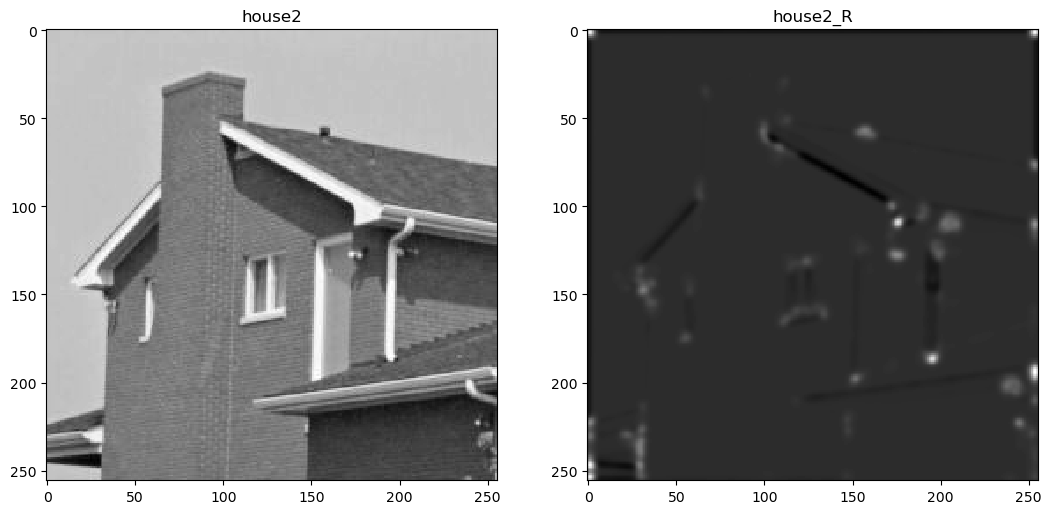

In [43]:
house2 = np.array(Image.open('img/house2.png'))
house2_R = computeR(house2,15,0.04)


niceDisplay14([house2,house2_R],['house2','house2_R'])

3) Write in a few lines an interpretation of the results, explaining how the Harris response allows to detect and discriminate homogeneous areas, edges and corners.

**the Harris response allows us to discriminate between different image structures by quantifying the extent of intensity variation in multiple directions. Homogeneous regions have low Harris responses, edges have moderate responses, and corners have high responses.**

## Exercise 2 : Harris corner detector
From the Harris response calculated at exercise 1, we will write all the functions needed for the Harris detector. Write the following functions: 

1) A function `thresholdR(R, thres)` that calculates and returns the binary thresholding $R_b$ of the response $R$ according to the threshold $thres$

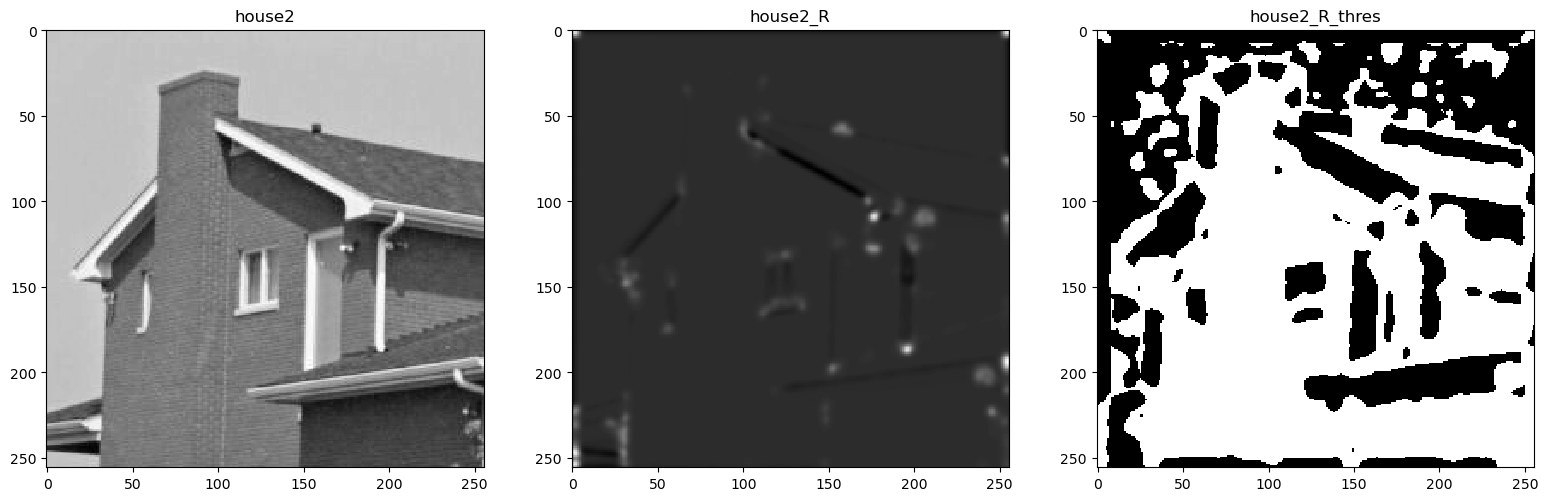

In [44]:
def thresholdR(R, thres):
    """ Array[n, m] * float -> Array[n, m]"""
    # Create a binary mask where R values above the threshold are set to 1, and others to 0
    R_b = np.where(R > thres, 1, 0)
    
    return R_b

house2_R_thres = thresholdR(house2_R,150)
niceDisplay14([house2,house2_R,house2_R_thres],['house2','house2_R','house2_R_thres'])

2) A function `Rnms(R, Rbin)` that performs a non-maximum supression from the response $R$ and the binarized response $R_{bin}$. It returns the image $R_{locmax}$ (same size as $R$) =1 where $R_{bin}=1$ and the pixel has a greater value $R$ than its 8 nearest neighbors.

**Bonus**: Write a faster version of the script using Numpy function `np.roll()`.

In [45]:
def Rnms(R, Rbin):
    R_locmax = np.zeros_like(Rbin)

    # Iterate over the image 
    for i in range(1, R.shape[0] - 1):
        for j in range(1, R.shape[1] - 1):

            if Rbin[i, j] == 1:
                # Extract the 3x3 neighborhood
                neighborhood = R[i-1:i+2, j-1:j+2]

                if R[i, j] >= np.max(neighborhood): 
                    R_locmax[i, j] = 1
    return R_locmax


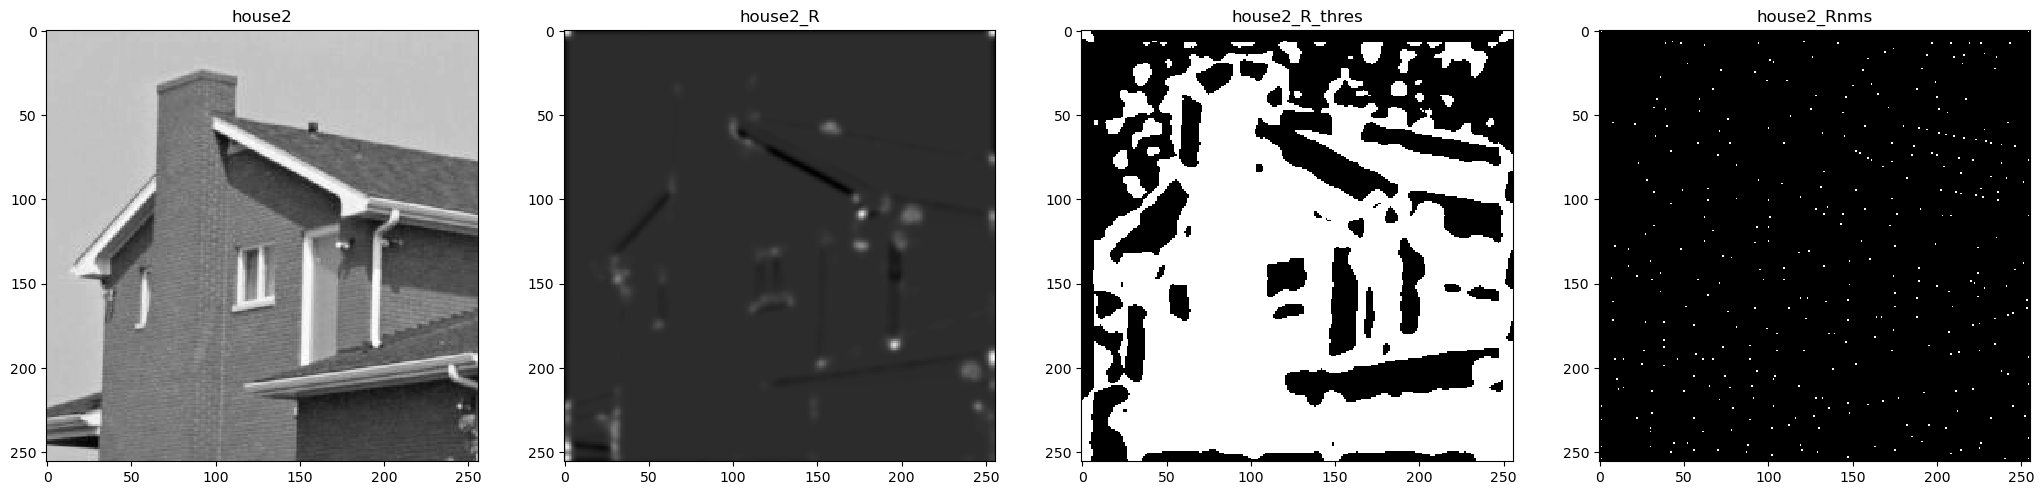

In [46]:
house2_rnms = Rnms(house2_R,house2_R_thres)
niceDisplay14([house2,house2_R,house2_R_thres,house2_rnms],['house2','house2_R','house2_R_thres','house2_Rnms'])

3) Write a function ``cornerDetector(image, scale, kappa, thresh)`` that returns an array of the same size as the image. The array takes two values: 1 where a corner is detected and 0 elsewhere.

In [47]:
import numpy as np

def cornerDetector(image, scale, kappa, thresh):
    # Step 1: Compute the Harris response
    R = computeR(image, scale, kappa)
    
    # Step 2: Threshold the Harris response
    R_bin = thresholdR(R, thresh)
    
    # Step 3: Apply non-maximum suppression
    R_locmax = Rnms(R, R_bin)
    
    return R_locmax


4 ) Display the detected corners on the original image for the image ```img/house2.png```. Each detected corner will be displayed as a small red disk. You can use the functions ```np.nonzero()``` and ```plt.scatter()``` to that purpose.

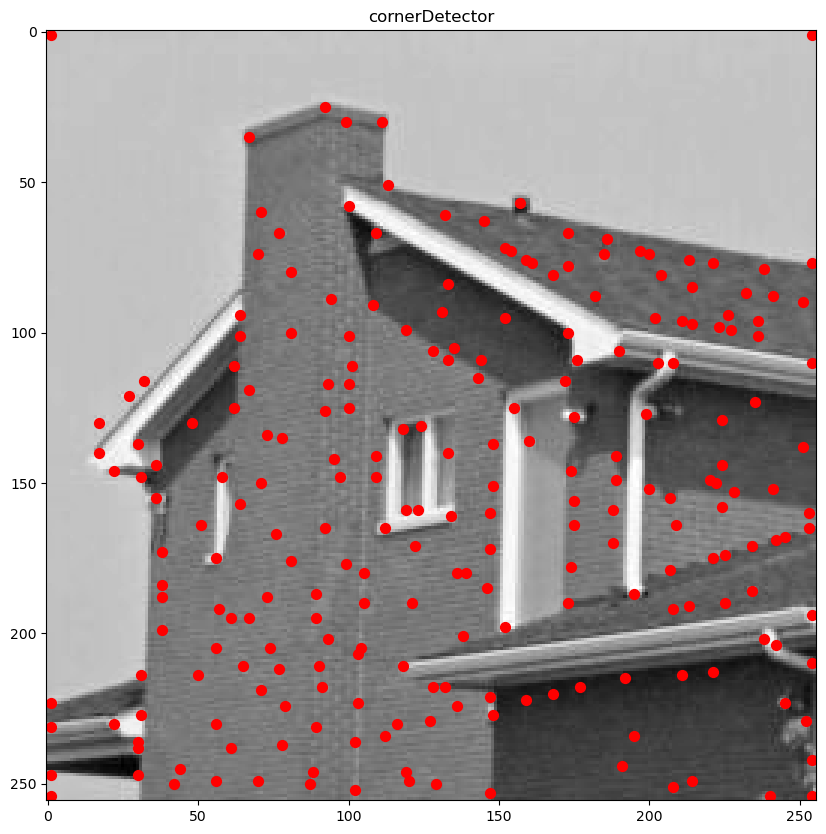

In [55]:
cornerDec = cornerDetector(house2, 15, 0.04, 1e5)

fig, ax = plt.subplots(figsize=(10,10))
plt.imshow(house2,cmap="gray")
plt.scatter(np.nonzero(cornerDec)[1], np.nonzero(cornerDec)[0], s=50, c="r")
plt.title("cornerDetector")
plt.show()

5) Evaluate the performances of the corner detector. Try to find good values for Sigma and Threshold.

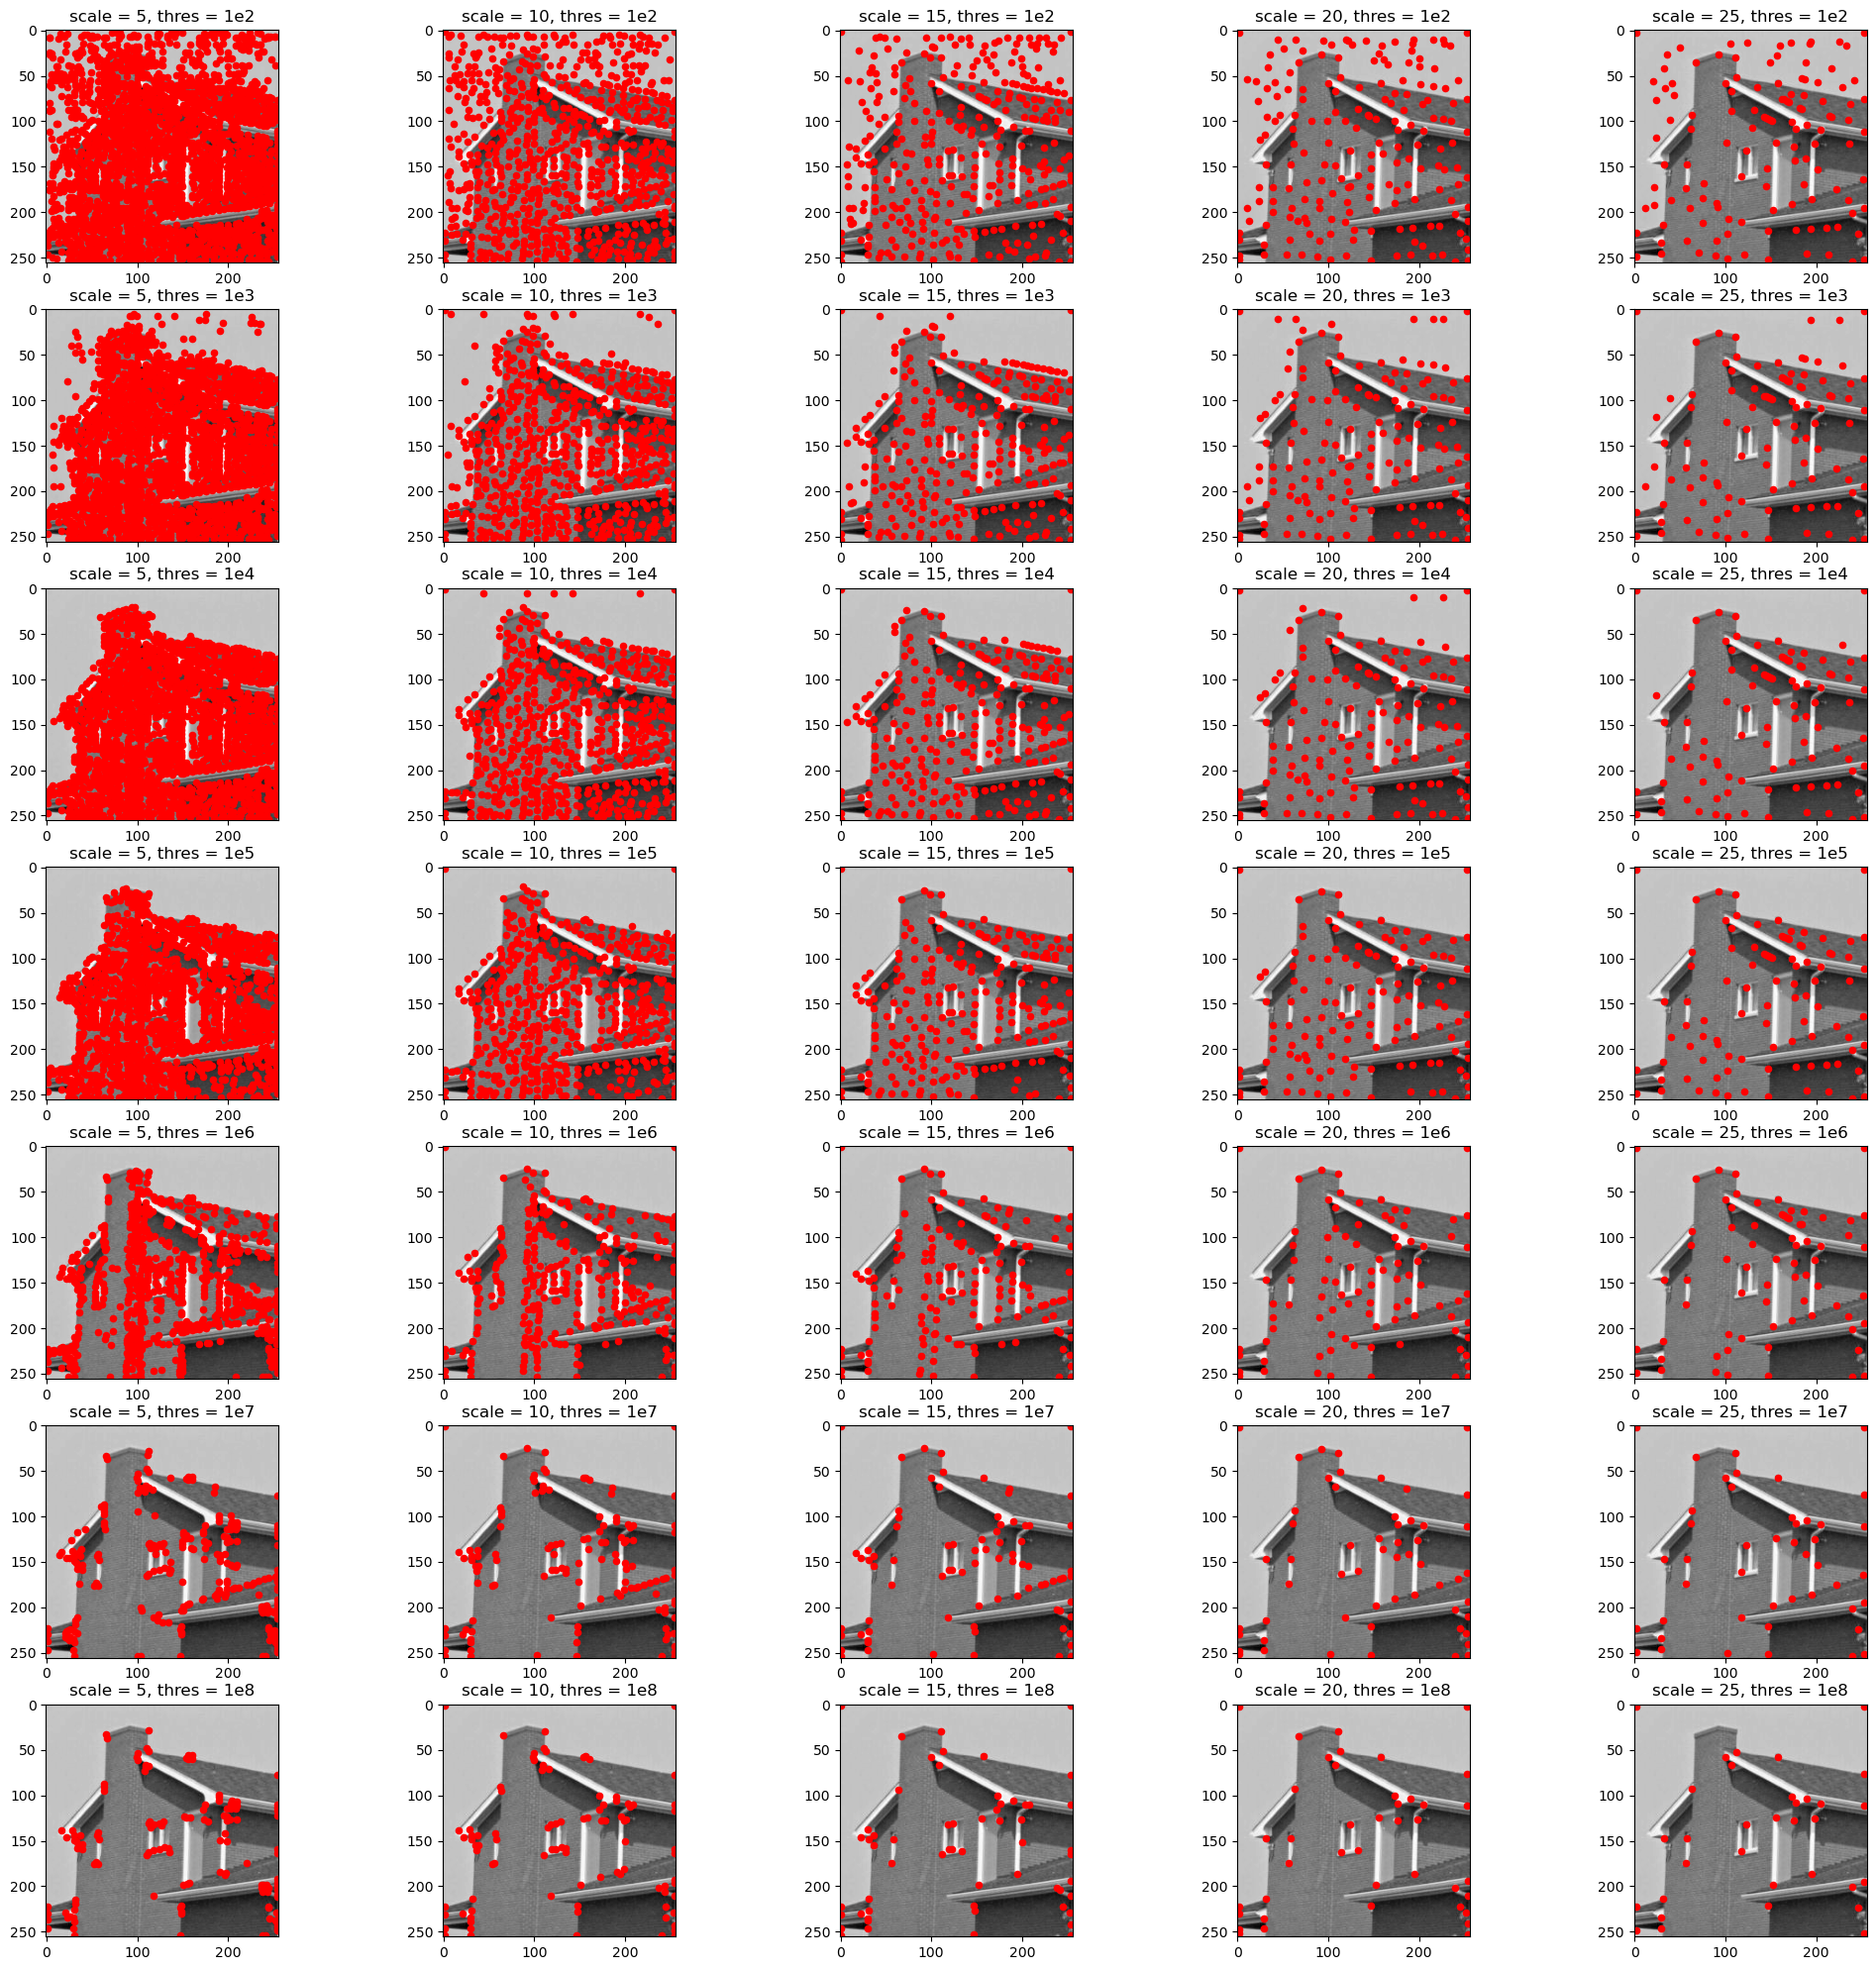

In [49]:
scales = list(range(5, 30, 5)) #5
threses = [1e2,1e3,1e4,1e5,1e6,1e7,1e8] #7

# Create subplots
fig, axes = plt.subplots(len(threses), len(scales), figsize=(25, 25))


for i in range(len(threses)):
    for j in range(len(scales)):
        cornerDec = cornerDetector(house2, scales[j], 0.04, threses[i])
        ax1 = axes[i, j]
        ax1.imshow(house2,cmap="gray")
        ax1.scatter(np.nonzero(cornerDec)[1], np.nonzero(cornerDec)[0], s=20, c="r")
        ax1.set(title = f'scale = {scales[j]}, thres = 1e{i+2}')


**For us, we prefer to choose scale = 20（$\sigma = 3.17$）and thres = 1e7. We can see in this situation, almost every corner is detected and don't have too much unimportant information is detected, like house tiles, sky.**

## Exercise 3 : Properties of Harris corner detector

The goal of this exercice is to study some invariance properties of Harris detector.

1) Write a script that detects the corners on the images ```img/toyHorse1.png``` and ```img/toyHorse2.png``` with a scale of 15 and appropriate threshold value. Display the detected corners on the images.

In [50]:
toy1 = np.array(Image.open("./img/toyHorse1.png"))
toy2 = np.array(Image.open("./img/toyHorse2.png"))

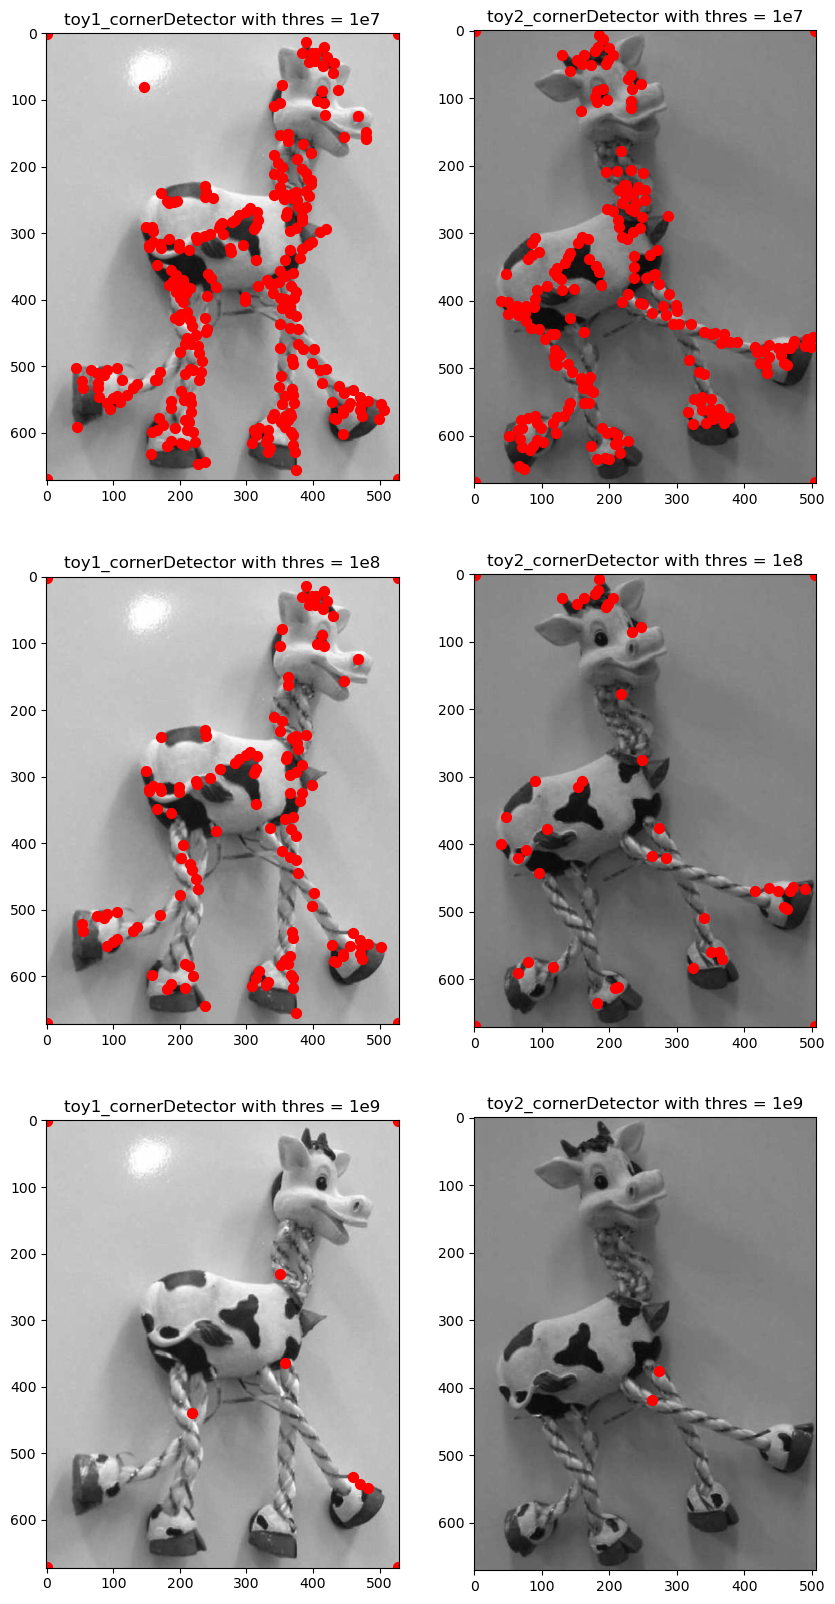

In [51]:
fig, ax = plt.subplots(3, 2, figsize=(10, 20))
thresh = [1e7,1e8,1e9]

for i in range(3):
    toy1_cornerDec = cornerDetector(toy1, 15, 0.04, thresh[i])
    toy2_cornerDec = cornerDetector(toy2, 15, 0.04, thresh[i])
    
    ax[i,0].imshow(toy1,cmap="gray")
    ax[i,0].scatter(np.nonzero(toy1_cornerDec)[1], np.nonzero(toy1_cornerDec)[0], s=50, c="r")
    ax[i,0].set(title = f'toy1_cornerDetector with thres = 1e{i+7}')

    ax[i,1].imshow(toy2,cmap="gray")
    ax[i,1].scatter(np.nonzero(toy2_cornerDec)[1], np.nonzero(toy2_cornerDec)[0], s=50, c="r")
    ax[i,1].set(title = f'toy2_cornerDetector with thres = 1e{i+7}')

plt.show()

**By the results of this three threshold values, it's clearly to choose the threshold value = 1e8**

2) What are the dynamic ranges of these two images ?

**This two images are both 8-bit image comprises 256 discrete brightness levels ($2^8 = 256$), so the dynamic ranges should be in $[0,256]$**

In [56]:
# Calculate the dynamic range for both images
dynamic_range1 = np.max(toy1) - np.min(toy1)
dynamic_range2 = np.max(toy2) - np.min(toy2)

print(f"Dynamic Range of toyHorse1.png: {dynamic_range1}")
print(f"Dynamic Range of toyHorse2.png: {dynamic_range2}")


Dynamic Range of toyHorse1.png: 254
Dynamic Range of toyHorse2.png: 253


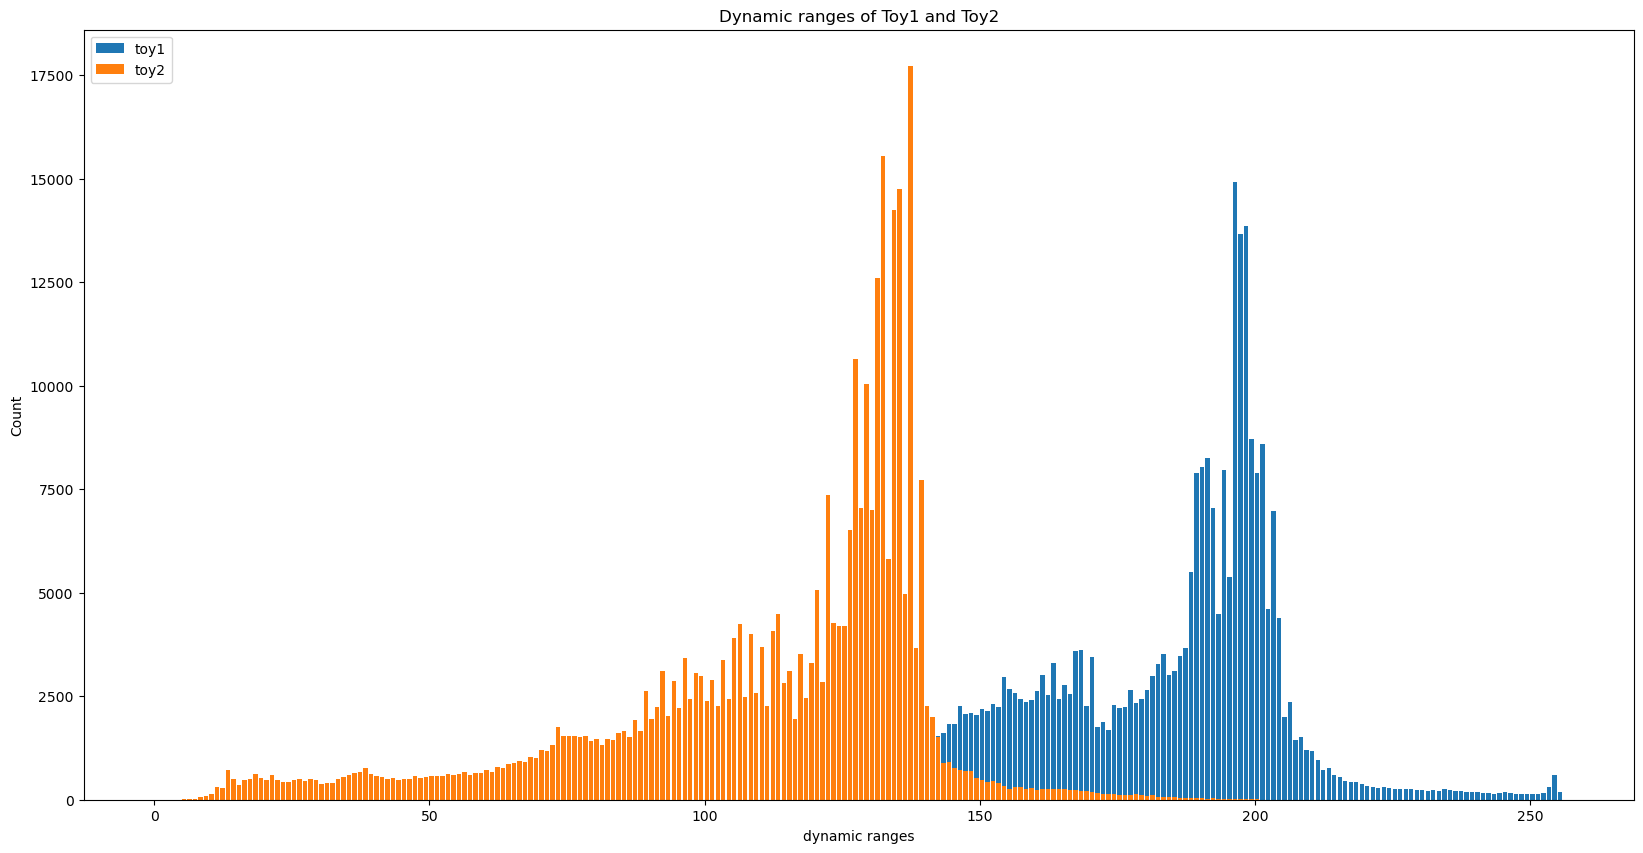

In [57]:
plt.figure(figsize=(20,10))
plt.hist(toy1.ravel(), 256, [0,256], width = 0.8, label="toy1")
plt.hist(toy2.ravel(), 256, [0,256], width = 0.8, label="toy2")
plt.legend(bbox_to_anchor=(0, 1), loc='upper left')
plt.ylabel('Count')
plt.xlabel('dynamic ranges')
plt.title('Dynamic ranges of Toy1 and Toy2')
plt.show()

3) What are the transformations beetween the two images ?

**The two images depict the same toy with consistent positioning but exhibit variations in lighting and perspective. The Harris corner detector effectively identifies and highlights key features, including the eyes, spots, legs, neck, and horns, showcasing its robustness in recognizing distinctive elements. However, the detector's sensitivity to lighting and perspective differences is evident in less well-delineated features, such as the ears.**

4) Using a fixed threshold, is the detection invariant to rotation ? To affine transformation of brightness ?

**Given the characteristics of the toy images and the Harris corner detector's response, it is evident that using a fixed threshold for corner detection does not achieve perfect invariance to rotation and brightness variations. As noted, the detected corners exhibit a degree of similarity, especially concerning key features like the eyes, spots, legs, neck, and horns. I think with a threshold that adapts to the specific image characteristics, the Harris detector could potentially exhibit improved invariance to rotation and variations in brightness. By dynamically adjusting the threshold based on local image properties, the detector could better accommodate changes in lighting and rotation, leading to a more robust and accurate corner detection process.**